# Testing Objective

Investigate how to incorporate large data source into training dataset without drastically increasing model training/tuning times

A comparison between:
1. All of the data
2. Balanced data
3. Randomly adding in data
4. Adding in data by lowest class precision * (main test)





## Create Train/Valid/Test Datasets + Supplemental Dataset

In [6]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [7]:
import pandas as pd
import numpy as np

In [8]:
# read the csv file into a DataFrame
df = pd.read_csv(r'jobboard_reed_uk_primary.csv')
supplemental = pd.read_csv(r'jobboard_reed_uk_secondary.csv')

In [9]:
# first lets stratify the train (+valid) and test data, such that the test data is reflective of the classes we might see
from sklearn.model_selection import train_test_split

train_valid, test = train_test_split(df, test_size=0.2, stratify=df["category"], random_state=42) 
train, valid = train_test_split(train_valid, test_size=0.25, stratify=train_valid["category"], random_state=42) 
print("training dataset: ", train.shape[0])
print("validation dataset: ", valid.shape[0])
print("testing dataset: ", test.shape[0])
print("supplemental dataset: ", supplemental.shape[0])

# display class sizes of train_valid split
df_group = train_valid.groupby(['category']).size().reset_index(name='labels').sort_values(by=['labels'], ascending=False)
df_group.head()

training dataset:  6000
validation dataset:  2000
testing dataset:  2000
supplemental dataset:  40000


,category,labels
34,social care jobs,337
9,education jobs,334
20,it jobs,318
0,accountancy jobs,311
18,health jobs,309


# Objective 1: Add all the data

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [14]:
df_primary = train.copy()
df_supplemental = supplemental.copy()
df_validation = valid.copy()
df_test = test.copy()

# merge primary and secondary data
primarydata = df_primary.append(df_supplemental)

# map each word in our training narratives to a vector position
vectorizer = CountVectorizer()
vectorizer.fit(primarydata['job_title'])

# convert each training narrative to its vector representation and stack them into a matrix
x_training = vectorizer.transform(primarydata['job_title'])
x_test = vectorizer.transform(df_test['job_title'])

# y_training contains the codes associated with our training narratives
y_training = primarydata['category']
y_test = df_test['category']

# create model, predict
clf = LogisticRegression(C=1.0)
clf.fit(x_training, y_training)

# predict on test data
y_test_pred = clf.predict(x_test)
y_test_prob = clf.predict_proba(x_test) # gives an array of all class probabilities
y_test_pred_prob = y_test_prob.max(axis=1) # find the highest prob, associated with clf.predict()

# generate parameters
accuracy = accuracy_score(y_test, y_test_pred)
records = primarydata.shape[0]

w_f1 = f1_score(y_test, y_test_pred, average = "weighted")
w_precision = precision_score(y_test, y_test_pred, average = "weighted")
w_recall = recall_score(y_test, y_test_pred, average = "weighted")    

# create a dataframe from the logged lists
df_iterations_all = pd.DataFrame(
    {'iteration': 1,
     'records': records,
      'weighted_f1': w_f1,
      'weighted_precision': w_precision,
      'weighted_recall': w_recall
     }, index=[0])
df_iterations_all.head()

,iteration,records,weighted_f1,weighted_precision,weighted_recall
0,1,46000,0.705745,0.711708,0.711


In [17]:
# save the predictions to a new dataframe for ensemble analysis
obj1_pred = y_test_pred.copy()
obj1_prob = y_test_pred_prob.copy()

# standard classification report
report = classification_report(y_test, y_test_pred, output_dict=True)
df_class_all = pd.DataFrame(report).transpose()
df_class_all["class"] = df_class_all.index
df_class_all = df_class_all.reset_index(drop=True)
df_class_all.head()

,f1-score,precision,recall,support,class
0,0.848101,0.837500,0.858974,78.0,accountancy jobs
1,0.784810,0.738095,0.837838,74.0,accountancy qualified jobs
2,0.670732,0.611111,0.743243,74.0,admin secretarial pa jobs
3,0.400000,0.400000,0.400000,5.0,apprenticeships jobs
4,0.582278,0.621622,0.547619,42.0,banking jobs


Text(0, 0.5, 'Classes')

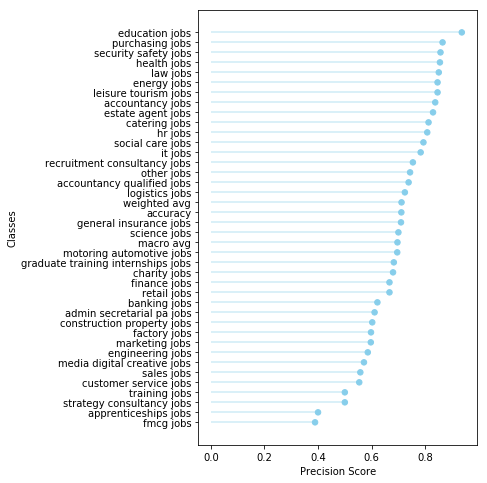

In [19]:
import matplotlib.pylab as plt
import seaborn as sns


df_plot = df_class_all.copy()
df_plot = df_plot.rename(columns={'class': 'group', 'precision':'values'})

# Reorder it following the values:
#del range
ordered_df = df_plot.sort_values(by='values')
my_range=range(1,len(ordered_df.index)+1)
 
# Create a color if the group is "B"
my_color=np.where(ordered_df ['group']=='B', 'orange', 'skyblue')
my_size=np.where(ordered_df ['group']=='B', 70, 30)

# The vertival plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns

plt.subplots(figsize=(5,8))
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['values'], color=my_color, alpha=0.4)
plt.scatter(ordered_df['values'], my_range, color=my_color, s=my_size, alpha=1)

# Add title and exis names
plt.yticks(my_range, ordered_df['group'])
#plt.title("What about the B group?", loc='left')
plt.xlabel('Precision Score')
plt.ylabel('Classes')

# Objective 2: Balanced Data (undersample)

In [20]:
# merge primary and secondary data
df_all = train.append(supplemental)
print(df_all.shape[0])

46000


### Undersample all data

In [21]:
# create a dataframe with count of labels
code = df_all[['category']]
code_count = code.groupby(['category']).size().reset_index(name='labels').sort_values(by='labels', ascending=False)
code_count = code_count.rename(columns={'category': 'class'})

# simple calculation on classes
median = np.percentile(code_count.labels, 50)
q1 = np.percentile(code_count.labels, 25)
mean = code_count.labels.mean()
print(mean)
print(median)
print(q1)

def subtract_value(value, row):
    value = int(value)
    row = int(row)
    if value < row:
        return value
    else:
        return row

code_count['undersample'] = code_count.apply(lambda row : int(subtract_value(q1, row["labels"])),axis = 1)

# create dictionary from undersampled values
zipbObj = zip(code_count['class'], code_count['undersample'])
dict_code = dict(zipbObj)

# undersample the dataframe
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy=dict_code)
df_undersample, y_rus = rus.fit_sample(df_all, df_all.category)
print("all records: ", df_all.shape[0])
print("undersampled records: ", df_undersample.shape[0])

1243.2432432432433
1404.0
883.0
all records:  46000
undersampled records:  30251


### Create the model

In [22]:
# map each word in our training narratives to a vector position
vectorizer = CountVectorizer()
vectorizer.fit(df_undersample['job_title'])

# convert each training narrative to its vector representation and stack them into a matrix
x_training = vectorizer.transform(df_undersample['job_title'])
x_test = vectorizer.transform(df_test['job_title'])

# y_training contains the codes associated with our training narratives
y_training = df_undersample['category']
y_test = df_test['category']

# create model, predict
clf = LogisticRegression(C=1.0)
clf.fit(x_training, y_training)

# predict on test data
y_test_pred = clf.predict(x_test)
y_test_prob = clf.predict_proba(x_test) # gives an array of all class probabilities
y_test_pred_prob = y_test_prob.max(axis=1) # find the highest prob, associated with clf.predict()

# generate parameters
accuracy = accuracy_score(y_test, y_test_pred)
records = df_undersample.shape[0]

w_f1 = f1_score(y_test, y_test_pred, average = "weighted")
w_precision = precision_score(y_test, y_test_pred, average = "weighted")
w_recall = recall_score(y_test, y_test_pred, average = "weighted")    

In [23]:
# save the predictions to a new dataframe for ensemble analysis
obj2_pred = y_test_pred.copy()
obj2_prob = y_test_pred_prob.copy()

In [24]:
# create a dataframe from the logged lists
df_iterations_balanced = pd.DataFrame(
    {'iteration': 1,
     'records': records,
      'weighted_f1': w_f1,
      'weighted_precision': w_precision,
      'weighted_recall': w_recall
     }, index=[0])

# standard classification report
report = classification_report(y_test, y_test_pred, output_dict=True)
df_class_balanced = pd.DataFrame(report).transpose()
df_class_balanced["class"] = df_class_balanced.index
df_class_balanced = df_class_balanced.reset_index(drop=True)
df_class_balanced.head()

,f1-score,precision,recall,support,class
0,0.838710,0.844156,0.833333,78.0,accountancy jobs
1,0.789809,0.746988,0.837838,74.0,accountancy qualified jobs
2,0.658065,0.629630,0.689189,74.0,admin secretarial pa jobs
3,0.545455,0.500000,0.600000,5.0,apprenticeships jobs
4,0.574468,0.519231,0.642857,42.0,banking jobs


In [56]:
df_iterations_balanced.head()

,iteration,records,weighted_f1,weighted_precision,weighted_recall
0,1,17266,0.647809,0.688899,0.6375


# Objective 3: randomly adding in data

## Creating the classification report

In [25]:
from sklearn.metrics import hamming_loss, classification_report, accuracy_score
#list_actual = df.code
#list_predicted = df.pred

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Generic Random Sample without Replacement

In [26]:

def expanded_classification_report(list_actual, list_predicted, trainingdata):

    # standard classification report
    report = classification_report(list_actual, list_predicted, output_dict=True)
    df_class = pd.DataFrame(report).transpose()
    df_class["class"] = df_class.index
    df_class = df_class.reset_index(drop=True)

    # create dataframe out of actual, predicted classes to find confused class
    df_lists = pd.DataFrame({'code': list_actual, 'pred': list_predicted})
    
    # find confused class
    def confused_class(code):    
        df_class = df_lists[df_lists["code"].astype(str) == str(code)]
        df_group = df_class.groupby(['pred']).size().reset_index(name='labels')
        df_group = df_group[df_group['pred'] != str(code)]
        df_group = df_group.sort_values(by=['labels'], ascending=False)
        most_confused = df_group.iloc[1,0]
        return most_confused

    df_class.drop(df_class.tail(3).index,inplace=True) # drop last 3 rows from dataframe b/c micro/macro/weighted averages
    df_class['confused_class'] = df_class.apply(lambda row: confused_class(row["class"]), axis=1)

    # count all labels in training dataset, !* change groupby to args category
    df_labels = trainingdata.groupby(['category']).size().reset_index(name='labels')
    df_labels = df_labels.rename(columns={'category': 'class'})

    def train_class_size(value):
        df_temp = df_labels[df_labels['class'].astype(str) == str(value)]
        count = df_temp.iloc[0,1]
        return count

    df_class['class_traindata'] = df_class.apply(lambda row: train_class_size(row["class"]), axis=1)
    df_class['confused_class_traindata'] = df_class.apply(lambda row: train_class_size(row["confused_class"]), axis=1)

    # select classes to add training data to
    df_class = df_class.sort_values(by=['precision'], ascending=True)
    df_class_selected = df_class.iloc[0:supplement_class_number,:]

    return df_class_selected


#df_class_selected = expanded_classification_report(list_actual, list_predicted, df)

#df_class_selected.head()

In [27]:
df_primary = train.copy()
df_supplemental = supplemental.sample(frac=1).reset_index(drop=True)
df_validation = valid.copy()
df_test = test.copy()

In [28]:
n_iterations = 20
step_value = 2000

log_accuracy = []
log_records = []
log_weighted_f1 = []
log_weighted_precision = []
log_weighted_recall = []
log_iteration = list(range(0, n_iterations))

for i in range(n_iterations):

    # create the training datasets
    def sample_without_replacement(dataframe):
        sample = dataframe[0:step_value]
        replace = dataframe.drop(dataframe.index[0:step_value])
        return replace, sample
    
    # create a definition to be able to write over the original training and supplemental datasets
    def run_iteration(primarydata, supplementaldata):
        
        # create two datasets, one to add to the primary and one to return at the end
        df_supplemental, sample = sample_without_replacement(supplementaldata)

        # add new data into training dataset
        df_primary = primarydata.append(sample)

        # map each word in our training narratives to a vector position
        vectorizer = CountVectorizer()
        vectorizer.fit(df_primary['job_title'])

        # convert each training narrative to its vector representation and stack them into a matrix
        x_training = vectorizer.transform(df_primary['job_title'])
        x_validation = vectorizer.transform(df_validation['job_title'])

        # y_training contains the codes associated with our training narratives
        y_training = df_primary['category']
        y_validation = df_validation['category']

        # create model, predict
        clf = LogisticRegression(C=1.0)
        clf.fit(x_training, y_training)
        y_validation_pred = clf.predict(x_validation)

        # generate parameters
        accuracy = accuracy_score(y_validation, y_validation_pred)
        records = df_primary.shape[0]
        
        w_f1 = f1_score(y_validation, y_validation_pred, average = "weighted")
        w_precision = precision_score(y_validation, y_validation_pred, average = "weighted")
        w_recall = recall_score(y_validation, y_validation_pred, average = "weighted")    
        
        
        print("Iteration:", i+1, ", size of primary dataset: ",df_primary.shape[0],", supplemental: ", df_supplemental.shape[0])
        
        return df_primary, df_supplemental, accuracy, records, w_f1, w_precision , w_recall
    
    df_primary, df_supplemental, accuracy, records, w_f1, w_precision , w_recall = run_iteration(df_primary, df_supplemental)
    
    log_accuracy.append(accuracy)
    log_records.append(records)
    log_weighted_f1.append(w_f1)
    log_weighted_precision.append(w_precision)
    log_weighted_recall.append(w_recall)



# create a dataframe from the logged lists
df_iterations_random = pd.DataFrame(
    {'iteration': log_iteration,
     'records': log_records,
      'weighted_f1': log_weighted_f1,
      'weighted_precision': log_weighted_precision,
      'weighted_recall': log_weighted_recall   
     })
df_iterations_random.head()


Iteration: 1 , size of primary dataset:  8000 , supplemental:  38000
Iteration: 2 , size of primary dataset:  10000 , supplemental:  36000
Iteration: 3 , size of primary dataset:  12000 , supplemental:  34000
Iteration: 4 , size of primary dataset:  14000 , supplemental:  32000
Iteration: 5 , size of primary dataset:  16000 , supplemental:  30000
Iteration: 6 , size of primary dataset:  18000 , supplemental:  28000
Iteration: 7 , size of primary dataset:  20000 , supplemental:  26000
Iteration: 8 , size of primary dataset:  22000 , supplemental:  24000
Iteration: 9 , size of primary dataset:  24000 , supplemental:  22000
Iteration: 10 , size of primary dataset:  26000 , supplemental:  20000
Iteration: 11 , size of primary dataset:  28000 , supplemental:  18000
Iteration: 12 , size of primary dataset:  30000 , supplemental:  16000
Iteration: 13 , size of primary dataset:  32000 , supplemental:  14000
Iteration: 14 , size of primary dataset:  34000 , supplemental:  12000
Iteration: 15 , 

,iteration,records,weighted_f1,weighted_precision,weighted_recall
0,0,8000,0.656610,0.662104,0.6635
1,1,10000,0.665703,0.675313,0.6720
2,2,12000,0.682450,0.689785,0.6870
3,3,14000,0.691579,0.697970,0.6960
4,4,16000,0.699506,0.705458,0.7035


In [29]:
# save the training data and results



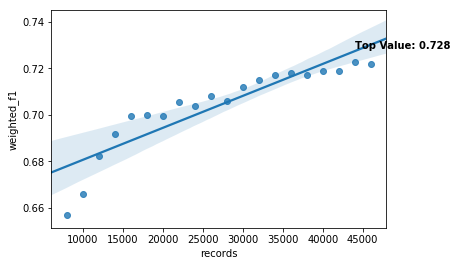

In [30]:
pl = sns.regplot(x=df_iterations_random["records"], y=df_iterations_random["weighted_f1"])

# add annotations one by one with a loop
#for line in range(0,df_iterations.shape[0]):
#     pl.text(df_iterations["records"][line]+0.4, df_iterations["weighted_precision"][line], df_iterations["iteration"][line], 
#             horizontalalignment='left', size='medium', color='black', weight='semibold')

# add annotation for hightest value
annotation = df_iterations_random.sort_values(by=['weighted_f1'], ascending=False)
x = annotation.iloc[0,1]
y = annotation.iloc[0,3]

pl.text(x+0.5, y, str("Top Value: "+str(round(y,3))), horizontalalignment='left', 
        size='medium', color='black', weight='semibold')
#sns.plt.show()

# save the figure to folder
#plt.subplots(figsize=(2,2))
#plt.tight_layout()
#plt.rcParams["figure.figsize"] = (20, 10)
plt.savefig(r"train_randomsample_withoutreplacement.png")


# Objective 4: sample based on class precision (without replacement)

### Expanded Classification Report

In [174]:
from sklearn.metrics import hamming_loss, classification_report, accuracy_score
#list_actual = df.code
#list_predicted = df.pred

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def expanded_classification_report(list_actual, list_predicted, trainingdata):

    # standard classification report
    report = classification_report(list_actual, list_predicted, output_dict=True)
    df_class = pd.DataFrame(report).transpose()
    df_class["class"] = df_class.index
    df_class = df_class.reset_index(drop=True)

    # create dataframe out of actual, predicted classes to find confused class
    df_lists = pd.DataFrame({'code': list_actual, 'pred': list_predicted})
    
    # find confused class
    def confused_class(code):    
        df_class = df_lists[df_lists['code'].astype(str) == str(code)]
        df_group = df_class.groupby(['pred']).size().reset_index(name='labels')
        df_group = df_group[df_group['pred'] != str(code)]
        df_group = df_group.sort_values(by=['labels'], ascending=False)
        if df_group.shape[0] == 0 or df_group.shape[0] == 1:
            return code
        else:
            most_confused = df_group.iloc[1,0]
            return most_confused

    df_class.drop(df_class.tail(3).index,inplace=True) # drop last 3 rows from dataframe b/c micro/macro/weighted averages
    df_class['confused_class'] = df_class.apply(lambda row: confused_class(row["class"]), axis=1)

    # count all labels in training dataset, !* change groupby to args category
    df_labels = trainingdata.groupby(['category']).size().reset_index(name='labels')
    df_labels = df_labels.rename(columns={'category': 'class'})

    def train_class_size(value):
        df_temp = df_labels[df_labels['class'].astype(str) == str(value)]
        count = df_temp.iloc[0,1]
        return count

    df_class['class_traindata'] = df_class.apply(lambda row: train_class_size(row["class"]), axis=1)
    df_class['confused_class_traindata'] = df_class.apply(lambda row: train_class_size(row["confused_class"]), axis=1)

    # select classes to add training data to
    df_class = df_class.sort_values(by=['precision'], ascending=True)
    df_class_selected = df_class.iloc[0:supplement_class_number,:]

    return df_class_selected


### Function to replace existing datasets for iterations

In [173]:

# create a definition to be able to write over the original training and supplemental datasets
def supplement_trainingdata(classes_selected, primarydata, supplementaldata):

    # determine which class to add to
    column_names = list(supplementaldata.columns)  
    add_labels = []
    
    for index,row in classes_selected.iterrows():
        
        # determine basic vales to compare against class and its confused class
        difference = abs(row["class_traindata"] - row["confused_class_traindata"])
        primary_class = row["class"]
        primary_class_labels = int(row["class_traindata"])

        confused_class = row["confused_class"]
        confused_class_labels = int(row["confused_class_traindata"])

        # if difference is less than a certain value then we need to add more labels to both classes 
        if difference < 20:
            primary_temp = supplementaldata[supplementaldata["category"].astype(str) == str(primary_class)] # find class
            primary_temp = primary_temp.iloc[0:step_value].values.tolist() # take the number of rows according to step value
            add_labels.extend(primary_temp) # append new labels to our add_labels list

            confused_temp = supplementaldata[supplementaldata["category"].astype(str) == str(confused_class)]
            confused_temp = confused_temp.iloc[0:step_value].values.tolist()
            add_labels.extend(confused_temp)

        # if difference is greater than a certain value we only add labels to the minority class
        if difference > 20 and primary_class_labels < confused_class_labels:
            primary_temp = supplementaldata[supplementaldata["category"].astype(str) == str(primary_class)]
            primary_temp = primary_temp.iloc[0:step_value].values.tolist()
            add_labels.extend(primary_temp)

        if difference > 20 and primary_class_labels > confused_class_labels:
            confused_temp = supplementaldata[supplementaldata["category"].astype(str) == str(confused_class)]
            confused_temp = confused_temp.iloc[0:step_value].values.tolist()
            add_labels.extend(confused_temp)

    # create dataframe out of added labels
    df_add_labels = pd.DataFrame(add_labels, columns = column_names)
    
    # remove added labels from supplemental dataset to ensure 
    df_supp_withoutreplacement = df_supplemental.append(df_add_labels)
    df_supp_withoutreplacement.drop_duplicates(keep = False, inplace = True)
    #df_supp_withoutreplacement.reset_index(drop=True) # reset the index to be able to take first rows again

    # add new labels to training data
    training_data = df_primary.copy()
    training_data_new = training_data.append(df_add_labels)

    return training_data_new, df_supp_withoutreplacement


#df_primary, df_supplemental =  supplement_trainingdata(df_class_selected, df_primary, df_supplemental)


### Run Iterations

#### Here we try a large class number to add to 

In [71]:
n_iterations = 30
step_value = 50
supplement_class_number = 20

df_primary = train.copy()
df_supplemental = supplemental.copy()
df_validation = valid.copy()

log_accuracy = []
log_records = []
log_weighted_f1 = []
log_weighted_precision = []
log_weighted_recall = []
log_iteration = list(range(0, n_iterations))

for i in range(n_iterations):

    
    # create a definition to be able to write over the original training and supplemental datasets
    def run_iteration(primarydata, supplementaldata):
        
        # map each word in our training narratives to a vector position
        vectorizer = CountVectorizer()
        vectorizer.fit(primarydata['job_title'])

        # convert each training narrative to its vector representation and stack them into a matrix
        x_training = vectorizer.transform(primarydata['job_title'])
        x_validation = vectorizer.transform(df_validation['job_title'])

        # y_training contains the codes associated with our training narratives
        y_training = primarydata['category']
        y_validation = df_validation['category']

        # create model, predict
        clf = LogisticRegression(C=1.0)
        clf.fit(x_training, y_training)
        y_validation_pred = clf.predict(x_validation)

        # generate parameters
        accuracy = accuracy_score(y_validation, y_validation_pred)
        records = primarydata.shape[0]
        
        w_f1 = f1_score(y_validation, y_validation_pred, average = "weighted")
        w_precision = precision_score(y_validation, y_validation_pred, average = "weighted")
        w_recall = recall_score(y_validation, y_validation_pred, average = "weighted")    
        
        
        ## generate new datasets based on errors of current model
        df_class_selected = expanded_classification_report(y_validation, y_validation_pred, primarydata)
        
        ## supplement training data based on low precision in selected classes
        df_primary, df_supplemental =  supplement_trainingdata(df_class_selected, primarydata, supplementaldata)
        
        # report iterations
        print("Iteration:", i+1, ", size of primary dataset: ",df_primary.shape[0],", supplemental: ", df_supplemental.shape[0])
        
        return df_primary, df_supplemental, accuracy, records, w_f1, w_precision , w_recall
    
    df_primary, df_supplemental, accuracy, records, w_f1, w_precision , w_recall = run_iteration(df_primary, df_supplemental)
    
    log_accuracy.append(accuracy)
    log_records.append(records)
    log_weighted_f1.append(w_f1)
    log_weighted_precision.append(w_precision)
    log_weighted_recall.append(w_recall)

# create a dataframe from the logged lists
df_iterations = pd.DataFrame(
    {'iteration': log_iteration,
     'records': log_records,
      'weighted_f1': log_weighted_f1,
      'weighted_precision': log_weighted_precision,
      'weighted_recall': log_weighted_recall   
     })
df_iterations.head()


Iteration: 1 , size of primary dataset:  7200 , supplemental:  39050
Iteration: 2 , size of primary dataset:  8398 , supplemental:  38051
Iteration: 3 , size of primary dataset:  9423 , supplemental:  37126
Iteration: 4 , size of primary dataset:  10423 , supplemental:  36276
Iteration: 5 , size of primary dataset:  11623 , supplemental:  35376
Iteration: 6 , size of primary dataset:  12673 , supplemental:  34376
Iteration: 7 , size of primary dataset:  13673 , supplemental:  33476
Iteration: 8 , size of primary dataset:  14723 , supplemental:  32676
Iteration: 9 , size of primary dataset:  15823 , supplemental:  31726
Iteration: 10 , size of primary dataset:  16773 , supplemental:  30876
Iteration: 11 , size of primary dataset:  17773 , supplemental:  29976
Iteration: 12 , size of primary dataset:  18787 , supplemental:  29044
Iteration: 13 , size of primary dataset:  19637 , supplemental:  28194
Iteration: 14 , size of primary dataset:  20637 , supplemental:  27344
Iteration: 15 , si

,iteration,records,weighted_f1,weighted_precision,weighted_recall
0,0,6000,0.639844,0.644457,0.6475
1,1,7200,0.656227,0.665026,0.6565
2,2,8398,0.660589,0.671680,0.6585
3,3,9423,0.661431,0.674227,0.6575
4,4,10423,0.664716,0.680515,0.6590


In [81]:
df_iterations_large = df_iterations.copy()

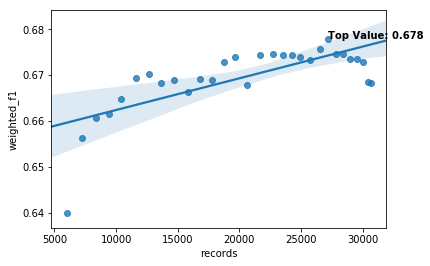

In [82]:
import matplotlib.pylab as plt
import seaborn as sns

pl = sns.regplot(x=df_iterations_large["records"], y=df_iterations_large["weighted_f1"])

# add annotations one by one with a loop
#for line in range(0,df_iterations.shape[0]):
#     pl.text(df_iterations["records"][line]+0.4, df_iterations["weighted_precision"][line], df_iterations["iteration"][line], 
#             horizontalalignment='left', size='medium', color='black', weight='semibold')

# add annotation for hightest value
annotation = df_iterations_large.sort_values(by=['weighted_f1'], ascending=False)
x = annotation.iloc[0,1]
y = annotation.iloc[0,2]

pl.text(x+0.01, y, str("Top Value: "+str(round(y,3))), horizontalalignment='left', 
        size='medium', color='black', weight='semibold')
#sns.plt.show()

plt.savefig(r"train_iterative_sampleclassf1.png")

#### Focused on lowest classes

In [175]:
n_iterations = 30
step_value = 50
supplement_class_number = 5

df_primary = train.copy()
df_supplemental = supplemental.copy()
df_validation = valid.copy()

log_accuracy = []
log_records = []
log_weighted_f1 = []
log_weighted_precision = []
log_weighted_recall = []
log_iteration = list(range(0, n_iterations))

for i in range(n_iterations):

    
    # create a definition to be able to write over the original training and supplemental datasets
    def run_iteration(primarydata, supplementaldata):
        
        # map each word in our training narratives to a vector position
        vectorizer = CountVectorizer()
        vectorizer.fit(primarydata['job_title'])

        # convert each training narrative to its vector representation and stack them into a matrix
        x_training = vectorizer.transform(primarydata['job_title'])
        x_validation = vectorizer.transform(df_validation['job_title'])

        # y_training contains the codes associated with our training narratives
        y_training = primarydata['category']
        y_validation = df_validation['category']

        # create model, predict
        clf = LogisticRegression(C=1.0)
        clf.fit(x_training, y_training)
        y_validation_pred = clf.predict(x_validation)

        # generate parameters
        accuracy = accuracy_score(y_validation, y_validation_pred)
        records = primarydata.shape[0]
        
        w_f1 = f1_score(y_validation, y_validation_pred, average = "weighted")
        w_precision = precision_score(y_validation, y_validation_pred, average = "weighted")
        w_recall = recall_score(y_validation, y_validation_pred, average = "weighted")    
        
        
        ## generate new datasets based on errors of current model
        df_class_selected = expanded_classification_report(y_validation, y_validation_pred, primarydata)
        
        ## supplement training data based on low precision in selected classes
        df_primary, df_supplemental =  supplement_trainingdata(df_class_selected, primarydata, supplementaldata)
        
        # report iterations
        print("Iteration:", i+1, ", size of primary dataset: ",df_primary.shape[0],", supplemental: ", df_supplemental.shape[0])
        
        return df_primary, df_supplemental, accuracy, records, w_f1, w_precision , w_recall
    
    df_primary, df_supplemental, accuracy, records, w_f1, w_precision , w_recall = run_iteration(df_primary, df_supplemental)
    
    log_accuracy.append(accuracy)
    log_records.append(records)
    log_weighted_f1.append(w_f1)
    log_weighted_precision.append(w_precision)
    log_weighted_recall.append(w_recall)

# create a dataframe from the logged lists
df_iterations = pd.DataFrame(
    {'iteration': log_iteration,
     'records': log_records,
      'weighted_f1': log_weighted_f1,
      'weighted_precision': log_weighted_precision,
      'weighted_recall': log_weighted_recall   
     })
df_iterations.head()


Iteration: 1 , size of primary dataset:  6300 , supplemental:  39700
Iteration: 2 , size of primary dataset:  6648 , supplemental:  39401
Iteration: 3 , size of primary dataset:  6898 , supplemental:  39151
Iteration: 4 , size of primary dataset:  7198 , supplemental:  38851
Iteration: 5 , size of primary dataset:  7498 , supplemental:  38651
Iteration: 6 , size of primary dataset:  7748 , supplemental:  38451
Iteration: 7 , size of primary dataset:  7948 , supplemental:  38251
Iteration: 8 , size of primary dataset:  8248 , supplemental:  37951
Iteration: 9 , size of primary dataset:  8548 , supplemental:  37751
Iteration: 10 , size of primary dataset:  8748 , supplemental:  37551
Iteration: 11 , size of primary dataset:  8998 , supplemental:  37301
Iteration: 12 , size of primary dataset:  9248 , supplemental:  37051
Iteration: 13 , size of primary dataset:  9498 , supplemental:  36801
Iteration: 14 , size of primary dataset:  9798 , supplemental:  36501
Iteration: 15 , size of prima

,iteration,records,weighted_f1,weighted_precision,weighted_recall
0,0,6000,0.639844,0.644457,0.6475
1,1,6300,0.650322,0.663043,0.6540
2,2,6648,0.653163,0.671704,0.6550
3,3,6898,0.656635,0.679087,0.6585
4,4,7198,0.657560,0.686955,0.6580


In [176]:
df_iterations.head(20)

,iteration,records,weighted_f1,weighted_precision,weighted_recall
0,0,6000,0.639844,0.644457,0.6475
1,1,6300,0.650322,0.663043,0.6540
2,2,6648,0.653163,0.671704,0.6550
3,3,6898,0.656635,0.679087,0.6585
4,4,7198,0.657560,0.686955,0.6580
5,5,7498,0.655742,0.690876,0.6540
6,6,7748,0.655437,0.691585,0.6535
7,7,7948,0.660184,0.700903,0.6560
8,8,8248,0.659063,0.703920,0.6550
9,9,8548,0.657105,0.707482,0.6515


### Final Run


In [177]:
# save final training data to a new dataframe to avoid overriding later on
df_iteration_train = df_primary.copy()
print(df_iteration_train.shape[0])

14596


In [178]:
# map each word in our training narratives to a vector position
vectorizer = CountVectorizer()
vectorizer.fit(df_iteration_train['job_title'])

# convert each training narrative to its vector representation and stack them into a matrix
x_training = vectorizer.transform(df_iteration_train['job_title'])
x_test = vectorizer.transform(df_test['job_title'])

# y_training contains the codes associated with our training narratives
y_training = df_iteration_train['category']
y_test = df_test['category']

# create model, predict
clf = LogisticRegression(C=1.0)
clf.fit(x_training, y_training)

y_test_pred = clf.predict(x_test)
y_test_prob = clf.predict_proba(x_test) # gives an array of all class probabilities
y_test_pred_prob = y_test_prob.max(axis=1) # find the highest prob, associated with clf.predict()

# generate parameters
accuracy = accuracy_score(y_test, y_test_pred)
records = df_primary.shape[0]

w_f1 = f1_score(y_test, y_test_pred, average = "weighted")
w_precision = precision_score(y_test, y_test_pred, average = "weighted")
w_recall = recall_score(y_test, y_test_pred, average = "weighted")  

# standard classification report
report = classification_report(y_test, y_test_pred, output_dict=True)
df_class = pd.DataFrame(report).transpose()
df_class["class"] = df_class.index
df_class = df_class.reset_index(drop=True)
df_class.head()

,f1-score,precision,recall,support,class
0,0.791367,0.901639,0.705128,78.0,accountancy jobs
1,0.771084,0.695652,0.864865,74.0,accountancy qualified jobs
2,0.541485,0.400000,0.837838,74.0,admin secretarial pa jobs
3,0.615385,0.500000,0.800000,5.0,apprenticeships jobs
4,0.460317,0.345238,0.690476,42.0,banking jobs


In [179]:
# save the predictions to a new dataframe for ensemble analysis
obj4_pred = y_test_pred.copy()
obj4_prob = y_test_pred_prob.copy()

In [180]:
'''
# create a dataframe from the logged predictions
df_pred = pd.DataFrame({'code':y_test,
     'pred': y_test_pred,
      'score': y_test_pred_prob  
     })

# create a threshold report
range = np.arange(0.5, 1.0, 0.01).tolist()
range.sort(reverse=True)
df_scores = pd.DataFrame(range, columns=['confidence'])

def threshold_error(data, value):
    df_temp = data[data['score'] > value]
    accuracy = round(accuracy_score(df_temp.code, df_temp.pred) * 100, 2)
    error_rate = 100 - accuracy
    return error_rate

def threshold_percent(data, value):
    count_overall = data.shape[0]
    df_temp = data[data['score'] > value]
    count_threshold = df_temp.shape[0]
    percent = round((count_threshold / count_overall) * 100, 2)
    return percent

# find error rates for each threshold applied
df_scores["error_rate"] = df_scores.apply(lambda row: threshold_error(df_pred, row['confidence']), axis=1)
df_scores.confidence = df_scores.confidence * 10

df_scores.head()

# select a confidence level based on a 5% error threshold
error_tolerance = 10
df_selected = df_scores.iloc[(df_scores['error_rate'] - error_tolerance).abs().argsort()[:2]]
threshold_selected = float(df_selected.confidence.iloc[0] / 10)

# create a new dataframe above threshold
df_threshold = df_pred[df_pred['score'] > threshold_selected]
print("records before threshold: ", df_pred.shape[0])
print("records after threshold: ", df_threshold.shape[0])

# standard classification report
report = classification_report(df_threshold.code, df_threshold.pred, output_dict=True)
df_threshold_class = pd.DataFrame(report).transpose()
df_threshold_class["class"] = df_threshold_class.index
df_threshold_class = df_threshold_class.reset_index(drop=True)
df_threshold_class.head()

'''

'\n# create a dataframe from the logged predictions\ndf_pred = pd.DataFrame({\'code\':y_test,\n     \'pred\': y_test_pred,\n      \'score\': y_test_pred_prob  \n     })\n\n# create a threshold report\nrange = np.arange(0.5, 1.0, 0.01).tolist()\nrange.sort(reverse=True)\ndf_scores = pd.DataFrame(range, columns=[\'confidence\'])\n\ndef threshold_error(data, value):\n    df_temp = data[data[\'score\'] > value]\n    accuracy = round(accuracy_score(df_temp.code, df_temp.pred) * 100, 2)\n    error_rate = 100 - accuracy\n    return error_rate\n\ndef threshold_percent(data, value):\n    count_overall = data.shape[0]\n    df_temp = data[data[\'score\'] > value]\n    count_threshold = df_temp.shape[0]\n    percent = round((count_threshold / count_overall) * 100, 2)\n    return percent\n\n# find error rates for each threshold applied\ndf_scores["error_rate"] = df_scores.apply(lambda row: threshold_error(df_pred, row[\'confidence\']), axis=1)\ndf_scores.confidence = df_scores.confidence * 10\n\ndf

### Visualizations

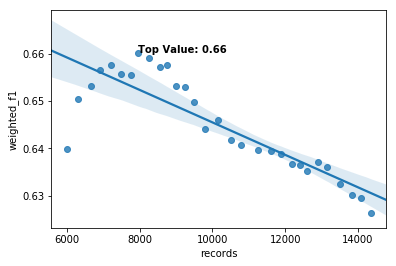

In [181]:
import matplotlib.pylab as plt
import seaborn as sns

pl = sns.regplot(x=df_iterations["records"], y=df_iterations["weighted_f1"])

# add annotations one by one with a loop
#for line in range(0,df_iterations.shape[0]):
#     pl.text(df_iterations["records"][line]+0.4, df_iterations["weighted_precision"][line], df_iterations["iteration"][line], 
#             horizontalalignment='left', size='medium', color='black', weight='semibold')

# add annotation for hightest value
annotation = df_iterations.sort_values(by=['weighted_f1'], ascending=False)
x = annotation.iloc[0,1]
y = annotation.iloc[0,2]

pl.text(x+0.01, y, str("Top Value: "+str(round(y,3))), horizontalalignment='left', 
        size='medium', color='black', weight='semibold')
#sns.plt.show()

plt.savefig(r"train_iterative_sampleclassf1.png")


when we optimize for precision our recall/f1 score starts to tank

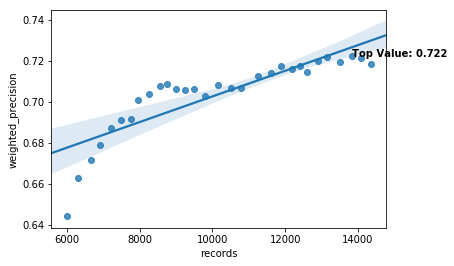

In [194]:
import matplotlib.pylab as plt
import seaborn as sns

pl = sns.regplot(x=df_iterations["records"], y=df_iterations["weighted_precision"])

# add annotations one by one with a loop
#for line in range(0,df_iterations.shape[0]):
#     pl.text(df_iterations["records"][line]+0.4, df_iterations["weighted_precision"][line], df_iterations["iteration"][line], 
#             horizontalalignment='left', size='medium', color='black', weight='semibold')

# add annotation for hightest value
annotation = df_iterations.sort_values(by=['weighted_precision'], ascending=False)
x = annotation.iloc[0,1]
y = annotation.iloc[0,3]

pl.text(x+0.01, y, str("Top Value: "+str(round(y,3))), horizontalalignment='left', 
        size='medium', color='black', weight='semibold')
#sns.plt.show()

plt.savefig(r"train_iterative_sampleclassf1.png")

Text(0, 0.5, 'Classes')

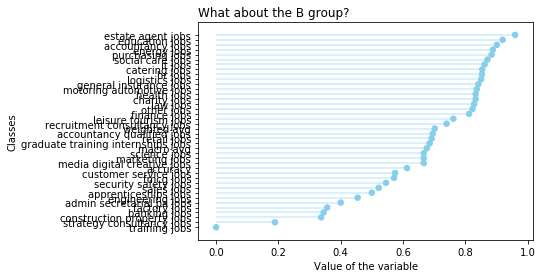

In [182]:
# testing lollipop data
# libraries
import pandas as pd
import matplotlib.pyplot as plt
 
df_plot = df_class.copy()
df_plot = df_plot.rename(columns={'class': 'group', 'precision':'values'})

# Reorder it following the values:
#del range
ordered_df = df_plot.sort_values(by='values')
my_range=range(1,len(ordered_df.index)+1)
 
# Create a color if the group is "B"
my_color=np.where(ordered_df ['group']=='B', 'orange', 'skyblue')
my_size=np.where(ordered_df ['group']=='B', 70, 30)

# The vertival plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['values'], color=my_color, alpha=0.4)
plt.scatter(ordered_df['values'], my_range, color=my_color, s=my_size, alpha=1)
 
# Add title and exis names
plt.yticks(my_range, ordered_df['group'])
plt.title("What about the B group?", loc='left')
plt.xlabel('Value of the variable')
plt.ylabel('Classes')



# Compare approaches

### Compare by classes

In [183]:
df_class_compare = pd.DataFrame(
    {'class': df_class_all['class'],
     'precision_all': df_class_all['precision'],
      'f1_all': df_class_all['f1-score'],
     'recall_all': df_class_all['recall'],
      'precision_iteration': df_class['precision'],
      'f1_iteration': df_class['f1-score'],
     'recall_iteration': df_class['recall']
     })

df_class_compare['difference'] = df_class_compare.precision_all - df_class_compare.precision_iteration
df_class_compare.head()

,class,precision_all,f1_all,recall_all,precision_iteration,f1_iteration,recall_iteration,difference
0,accountancy jobs,0.837500,0.848101,0.858974,0.901639,0.791367,0.705128,-0.064139
1,accountancy qualified jobs,0.738095,0.784810,0.837838,0.695652,0.771084,0.864865,0.042443
2,admin secretarial pa jobs,0.611111,0.670732,0.743243,0.400000,0.541485,0.837838,0.211111
3,apprenticeships jobs,0.400000,0.400000,0.400000,0.500000,0.615385,0.800000,-0.100000
4,banking jobs,0.621622,0.582278,0.547619,0.345238,0.460317,0.690476,0.276384


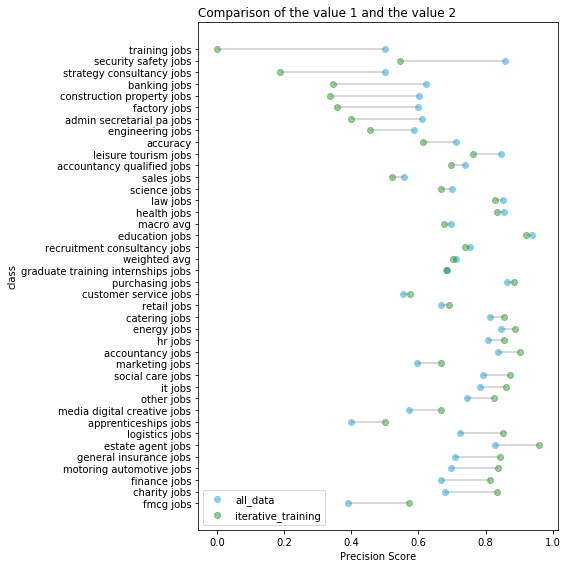

In [184]:
# Reorder it following the values of the first value:
del my_range

ordered_df = df_class_compare.sort_values(by='difference')
my_range=range(1,len(ordered_df.index)+1)
 
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns

plt.subplots(figsize=(8,8))
plt.hlines(y=my_range, xmin=ordered_df['precision_all'], xmax=ordered_df['precision_iteration'], color='grey', alpha=0.4)
plt.scatter(ordered_df['precision_all'], my_range, color='skyblue', alpha=1, label='all_data')
plt.scatter(ordered_df['precision_iteration'], my_range, color='green', alpha=0.4 , label='iterative_training')
plt.legend()
 
# Add title and axis names
plt.yticks(my_range, ordered_df['class'])
plt.title("Comparison of the value 1 and the value 2", loc='left')
plt.xlabel('Precision Score')
plt.ylabel('class')

# save the figure to folder
plt.tight_layout()
#plt.rcParams["figure.figsize"] = (20, 10)
plt.savefig(r"compare_alldata_iterativetraining.png")


It looks like each model is good a predicting diffent classes

## Ensemble predictions: take the prediction with the highest confidence

In [185]:
df_ensemble = pd.DataFrame(
    {'class': y_test,
     'pred_all': obj1_pred,
      'prob_all': obj1_prob,
     #'pred_balance': obj1_pred,
      #'prob_balance': obj1_prob,
      'pred_iteration': obj4_pred,
     'prob_iteration': obj4_prob
     })

df_ensemble.head(5)

,class,pred_all,prob_all,pred_iteration,prob_iteration
155,sales jobs,sales jobs,0.942517,sales jobs,0.507339
3720,it jobs,engineering jobs,0.923026,engineering jobs,0.810122
7177,accountancy qualified jobs,accountancy qualified jobs,0.842268,accountancy qualified jobs,0.863304
5161,marketing jobs,marketing jobs,0.799592,marketing jobs,0.786612
5710,motoring automotive jobs,motoring automotive jobs,0.926849,motoring automotive jobs,0.518213


In [186]:
# create a dataframe from the logged lists
df_iterations_balanced = pd.DataFrame(
    {'iteration': 1,
     'records': records,
      'weighted_f1': w_f1,
      'weighted_precision': w_precision,
      'weighted_recall': w_recall
     }, index=[0])

# standard classification report
report = classification_report(y_test, y_test_pred, output_dict=True)
df_class_balanced = pd.DataFrame(report).transpose()
df_class_balanced["class"] = df_class_balanced.index
df_class_balanced = df_class_balanced.reset_index(drop=True)
df_class_balanced.head()

,f1-score,precision,recall,support,class
0,0.791367,0.901639,0.705128,78.0,accountancy jobs
1,0.771084,0.695652,0.864865,74.0,accountancy qualified jobs
2,0.541485,0.400000,0.837838,74.0,admin secretarial pa jobs
3,0.615385,0.500000,0.800000,5.0,apprenticeships jobs
4,0.460317,0.345238,0.690476,42.0,banking jobs


In [187]:
#df_ensemble = df_ensemble[df_ensemble['class'] == "banking jobs"]
#df_ensemble.head(10)

### Take the model with the highest confidence level (not usable in ACE)

In [188]:
df_ensemble['max_prob'] = df_ensemble.max(axis=1)

preds = []

for index,row in df_ensemble.iterrows():
    if row['prob_all'] == row['max_prob']:
        preds.append(row['pred_all'])
        
    if row['prob_iteration'] == row['max_prob']:
        preds.append(row['pred_iteration'])
        
df_ensemble['max_pred'] = preds
    
df_ensemble.head()

,class,pred_all,prob_all,pred_iteration,prob_iteration,max_prob,max_pred
155,sales jobs,sales jobs,0.942517,sales jobs,0.507339,0.942517,sales jobs
3720,it jobs,engineering jobs,0.923026,engineering jobs,0.810122,0.923026,engineering jobs
7177,accountancy qualified jobs,accountancy qualified jobs,0.842268,accountancy qualified jobs,0.863304,0.863304,accountancy qualified jobs
5161,marketing jobs,marketing jobs,0.799592,marketing jobs,0.786612,0.799592,marketing jobs
5710,motoring automotive jobs,motoring automotive jobs,0.926849,motoring automotive jobs,0.518213,0.926849,motoring automotive jobs


In [189]:
w_f1 = f1_score(df_ensemble['class'], df_ensemble['pred_all'], average = "weighted")
w_precision = precision_score(df_ensemble['class'], df_ensemble['pred_all'], average = "weighted")
w_recall = recall_score(df_ensemble['class'], df_ensemble['pred_all'], average = "weighted") 

print("f1:", w_f1, ", precision:", w_precision,", recall:", w_recall)

f1: 0.7057449083798653 , precision: 0.7117078302470334 , recall: 0.711


In [190]:
w_f1 = f1_score(df_ensemble['class'], df_ensemble['pred_iteration'], average = "weighted")
w_precision = precision_score(df_ensemble['class'], df_ensemble['pred_iteration'], average = "weighted")
w_recall = recall_score(df_ensemble['class'], df_ensemble['pred_iteration'], average = "weighted") 

print("f1:", w_f1, ", precision:", w_precision,", recall:", w_recall)

f1: 0.6191216446430435 , precision: 0.7019365353106735 , recall: 0.613


In [191]:
w_f1 = f1_score(df_ensemble['class'], df_ensemble['max_pred'], average = "weighted")
w_precision = precision_score(df_ensemble['class'], df_ensemble['max_pred'], average = "weighted")
w_recall = recall_score(df_ensemble['class'], df_ensemble['max_pred'], average = "weighted") 

print("f1:", w_f1, ", precision:", w_precision,", recall:", w_recall)

f1: 0.6961163431569627 , precision: 0.7307745876487326 , recall: 0.697


Taking the max probability score results in only a slightly lower F1 score, better precision, but worse recall. Not the best option given the amount of iterations needed. Also not viable in current ACE environment. 

### Assign a threshold and have model A predict above, model B predict below (G-Code)

In [192]:
df_level = df_ensemble.copy()

... ongoing

# Conclusion

Seems to make two models that are good at predicting different classes, however we can't rely on confidence levels to determine which predictions to apply. 